In [1]:
# IMPORTS
import os
import numpy as np
from utils.data import read_stock_history, normalize
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
from model.td3.actor import TD3ActorNetwork
from model.td3.critic import TD3CriticNetwork
from model.td3.td3 import TD3
from stock_trading import StockActor, StockCritic, TD3StockActor, TD3StockCritic, obs_normalizer, get_model_path, get_result_path, test_model, get_variable_scope, test_model_multiple
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv
import numpy as np
import tflearn
import json
from stock_trading import test_portfolio_selection, test_portfolio_selection_multiple, plot_weights, plot_portfolio_values, results_table, results_table_row, returns_from_cumulative, extract_from_infos
from technical_indicators.technical_indicators import moving_average, exponential_moving_average, momentum, rate_of_change, bollinger_bands, trix, standard_deviation

tf.__version__
print("Imports Complete")







Imports Complete


In [2]:
model_dict = {
        'framework': 'TD3', 
        'window': 14, 
        'technical_indicators_flag': True
    }

In [3]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

predictor_type = 'lstm'
use_batch_norm = True
log_return = True
load_technical_indicators = True
technical_indicator_history = []
maximum_window = model_dict['window']
dates = []

In [4]:
# Open Config
config_file_path = 'config/stock.json'   
with open(config_file_path) as f:
    config = json.load(f)
assert config != None, "Can't load config file"

actor_learning_rate = config['actor learning rate']
critic_learning_rate = config['critic learning rate']

In [5]:
# Stock History
dataset_name = 'nyse_n'
history, assets, date_list = read_stock_history(filepath='utils/datasets/{}.h5'.format(dataset_name))
history = history[:, :, :4]
nb_classes = len(history) + 1
print("Dataset: {}".format(dataset_name))
print("Assets: {}".format(assets))
print("Stock History Shape: {}".format(history.shape))
print("Full Stock History Date Range: {} -> {}".format(date_list[0], date_list[-1]))

Dataset: nyse_n
Assets: ['ahp', 'alcoa', 'amer_brands', 'coke', 'comm_metals', 'dow_chem', 'Dupont', 'ford', 'ge', 'gm', 'hp', 'ibm', 'ingersoll', 'jnj', 'kimb-clark', 'kin_ark', 'Kodak', 'merck', 'mmm', 'morris', 'p_and_g', 'schlum', 'sher_will']
Stock History Shape: (23, 6430, 2)
Full Stock History Date Range: 02/01/1985 -> 30/06/2010


In [6]:
# Training/Testing Date Range
full_length = len(date_list)
train_test_ratio = 6/7
train_start_date = date_list[maximum_window]
train_end_date = date_list[(int)(full_length * train_test_ratio)-1]
test_start_date = date_list[(int)(full_length * train_test_ratio)]
test_end_date = date_list[full_length-2]
print("Training Date Range: {} -> {} ({} Steps)".format(train_start_date, train_end_date, 
                                                    (int)(date_list.index(train_end_date) - date_list.index(train_start_date))))
print("Testing Date Range: {} -> {} ({} Steps)".format(test_start_date, test_end_date, 
                                                    (int)(date_list.index(test_end_date) - date_list.index(test_start_date))))

Training Date Range: 22/01/1985 -> 02/11/2006 (5496 Steps)
Testing Date Range: 03/11/2006 -> 29/06/2010 (917 Steps)


In [7]:
# Generate Technical Indicators
def GenerateTechnicalIndicators(window_length, debug = False):
    if debug:
        print('history.shape: {}'.format(history.shape))

    # Check if just close is fed or full dataset
    if history.shape[2] == 4:
        # Get Close
        history_close = history[:, :, 3]
    elif history.shape[2] == 2:
        # Assume the one sent is the close price
        history_close = history[:, :, 1]

    if debug:
        print('history_close.shape: {}'.format(history_close.shape))

    # Add Technical Indicators to be included in state
    if technical_indicators_flag:
        technical_indicator_history = []

        # Close Price DataFrame for on-line Portfolio Selection
        temp_close_df = create_close_dataframe(history, assets, date_list)
        temp_close_df = convert_prices(temp_close_df, 'raw', True)    
        if debug:
            print('temp_close_df.shape: {}'.format(temp_close_df.shape))

        rmr_moving_average_df = full_rmr_moving_average(temp_close_df, window_length)
        for i in range(len(assets)):
            # Create List
            ti = []
            #ti.append([olmar_moving_average(temp_close_df[assets[i]], window_length)]) # Based on OLMAR
            ti.append([rmr_moving_average_df[assets[i]]]) # Based on RMR

            # Turn to Array
            ti = np.vstack(ti)

            ti_reshaped = []
            for j in range(temp_close_df.shape[0]):
                ti_reshaped.append(ti[:, j])   

            technical_indicator_history.append(ti_reshaped)

        technical_indicator_history = np.array(technical_indicator_history)    
        if debug:
            print('technical_indicators.shape: {}'.format(technical_indicator_history.shape)) 
    else:
        technical_indicator_history = None
        
    return technical_indicator_history

In [8]:
if load_technical_indicators:
    # Load Technical Indicators dataset
    ti_dict = np.load('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name),allow_pickle='TRUE').item()
else:
    ti_dict = {}
    distinct_window_lengths = []
    for m in model_dict:
        if m['window'] not in distinct_window_lengths:
            distinct_window_lengths.append(m['window'])
            technical_indicator_history = GenerateTechnicalIndicators(m['window'])
            ti_dict[m['window']] = technical_indicator_history
    np.save('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name), ti_dict) 

In [9]:
# instantiate environment
framework = model_dict['framework']
window_length = model_dict['window']
technical_indicators_flag = model_dict['technical_indicators_flag']

# Add name
if technical_indicators_flag:
    name = '{}_{}_window_{}_predictor_{}_rmr-pred'.format(dataset_name, framework, window_length, predictor_type)
else:
    name = '{}_{}_window_{}_predictor_{}'.format(dataset_name, framework, window_length, predictor_type)
model_dict['name'] = name

tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes]

if technical_indicators_flag:
    technical_indicator_history = ti_dict[window_length]
    state_dim = [nb_classes, window_length+technical_indicator_history.shape[2]]
else:
    state_dim = [nb_classes, window_length]

variable_scope = get_variable_scope(dataset_name, framework, window_length, predictor_type, 
                                    use_batch_norm, technical_indicators_flag)

with tf.variable_scope(variable_scope):

    if(framework == 'DDPG'):
        actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                           predictor_type, use_batch_norm)
        critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
        actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

        model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)
        summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)

        ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                          log_return=log_return, config_file='config/stock.json', 
                          model_save_path=model_save_path, summary_path=summary_path)
        ddpg_model.initialize(load_weights=True, verbose=True)

        # Add model
        model_dict['model'] = ddpg_model

    elif(framework == 'TD3'):
        actor = TD3StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                              predictor_type, use_batch_norm)
        critic = TD3StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(),
                 predictor_type=predictor_type, use_batch_norm=use_batch_norm,
                   inp_actions=actor.scaled_out)
        actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

        model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)
        summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)

        td3_model = TD3(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer, 
                        log_return=log_return, config_file='config/stock.json', 
                        model_save_path=model_save_path, summary_path=summary_path)
        td3_model.initialize(load_weights=True, verbose=True)

        # Add model
        model_dict['model'] = td3_model


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.





INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_14/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_14_batch_norm_te

----------------
## IN SAMPLE

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<Figure size 432x288 with 0 Axes>

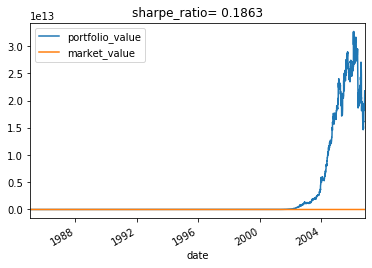

In [10]:
# Compiled Results
framework = model_dict['framework']
window_length = model_dict['window']
technical_indicators_flag = model_dict['technical_indicators_flag']
name = model_dict['name']
model = model_dict['model']

if technical_indicators_flag:
    env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                          end_date=train_end_date, window_length=window_length, 
                              technical_indicators_flag=True, 
                              technical_indicator_history=ti_dict[window_length])
else:
    env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                          end_date=train_end_date, window_length=window_length)


dates, observations, _, actions, weights_list, _, portfolio_values, in_market_portfolio_values = test_model(env, model)

model_dict['in_actions'] = actions
model_dict['in_portfolio_values'] = portfolio_values

#### Plot

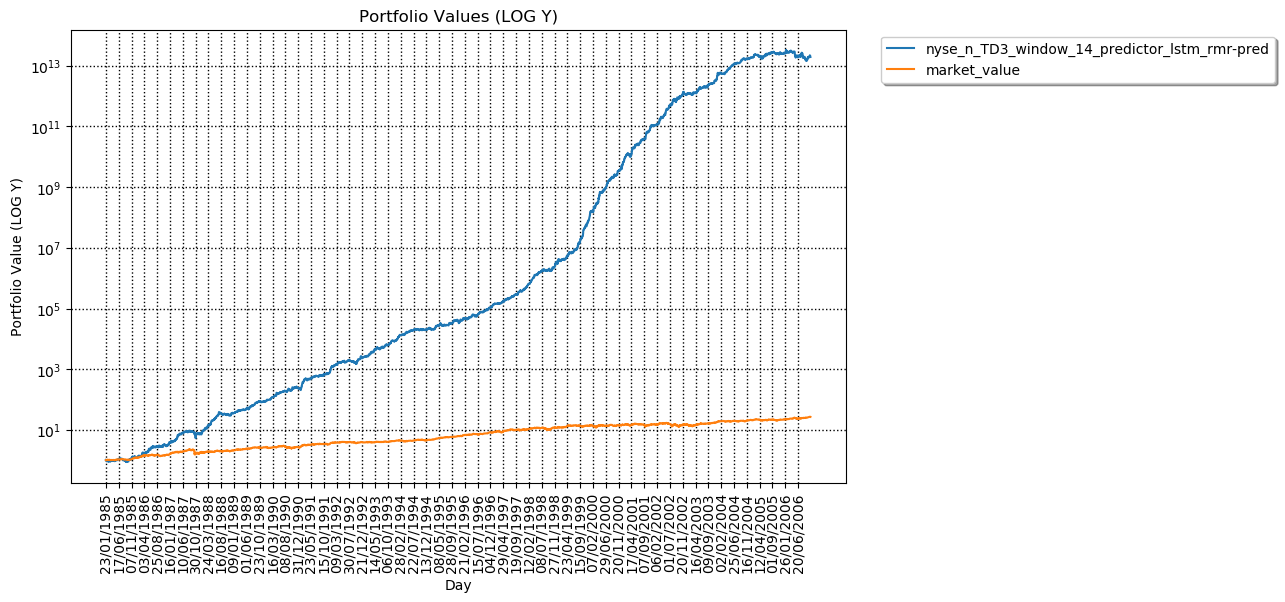

In [11]:
log_y = True
portfolio_df = pd.DataFrame()
portfolio_df["Date"] = dates
portfolio_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')
# Model
portfolio_df[model_dict['name']] = model_dict['in_portfolio_values']
plt.plot(portfolio_df[model_dict['name']], label=model_dict['name'])
# Market
portfolio_df['market_value'] = in_market_portfolio_values
plt.plot(portfolio_df['market_value'], label='market_value')
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

#### Results

In [12]:
# RESULT
df = pd.DataFrame(columns=['Portfolio', 'Average Daily Yield (%)', 'Sharpe Ratio (%)', 'Sortino Ratio (%)', 'Maximum Drawdown (%)',
                           'Final Portfolio Value'])

df = results_table_row(df, model_dict['name'],
                           returns_from_cumulative(model_dict['in_portfolio_values']),
                           model_dict['in_portfolio_values'])
# Market
df = results_table_row(df, 'market_value',
                           returns_from_cumulative(in_market_portfolio_values),
                           in_market_portfolio_values)
df

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,nyse_n_TD3_window_14_predictor_lstm_rmr-pred,0.6095,18.6155,32.4207,55.2066,1.953682e+13
1,market_value,0.0646,6.5845,8.4297,31.3973,2.691700e+01


#### Asset

In [13]:
full_assets = assets.copy()
full_assets.insert(0,'blank')
full_assets[0:5]

['blank', 'ahp', 'alcoa', 'amer_brands', 'coke']

In [14]:
# Asset Dataframe (return)
full_assets_df = pd.DataFrame(columns=assets)
for i in range(len(assets)):
    full_assets_df[assets[i]] = [item[1] for item in history[i]]
full_assets_df["blank"] = 1
full_assets_df["Date"] = date_list
full_assets_df.set_index('Date', inplace=True)

# testing subset
_start = np.where(full_assets_df.index==train_start_date)[0][0]
_end = np.where(full_assets_df.index==train_end_date)[0][0]
assets_df = full_assets_df[_start : _end]
#assets_df.head()

#### Weights

In [15]:
# Create Dataframe for weights
weights_df = pd.DataFrame(weights_list, columns=full_assets)
weights_df["Date"] = dates
weights_df.set_index('Date', inplace=True)
#weights_df.head()

In [16]:
# Lets check if weights are always equal to 1
for i in range(len(weights_df)):
    if np.sum(weights_df.iloc[2].values) > 1:
        print('We have a bug!')

### Subset for Granular Testing

In [17]:
# Subset by From and To Dates
from_date = '10/04/1995'
to_date = '15/05/1995'
subset_dates = date_list[date_list.index(from_date)-1 : 
                  date_list.index(to_date)]
_start = np.where(weights_df.index==from_date)[0][0]
_end = np.where(weights_df.index==to_date)[0][0]
subset_weights_df = weights_df[_start : _end]

# Normalised Subset Portfolio
subset_portfolio_df = portfolio_df[_start : _end]
subset_portfolio_df = ((subset_portfolio_df / subset_portfolio_df.shift(1)) - 1).cumsum() + 1
subset_portfolio_df.iloc[0] = 1

subset_assets = subset_weights_df.idxmax(axis=1).unique()
subset_assets_df = assets_df[_start : _end]
#subset_assets_df = subset_assets_df[subset_assets]

# Normalized
#diff_subset_assets_df = subset_assets_df - subset_assets_df.shift(1)
#normalized_subset_assets_df = diff_subset_assets_df.cumsum() + 1
#normalized_subset_assets_df.iloc[0] = 1

# Normalized
normalized_subset_assets_df = ((subset_assets_df / subset_assets_df.shift(1)) - 1).cumsum() + 1
normalized_subset_assets_df.iloc[0] = 1

# Log Return
log_return_subset_assets_df = np.log(subset_assets_df / subset_assets_df.shift(1))
#log_return_subset_assets_df.head()

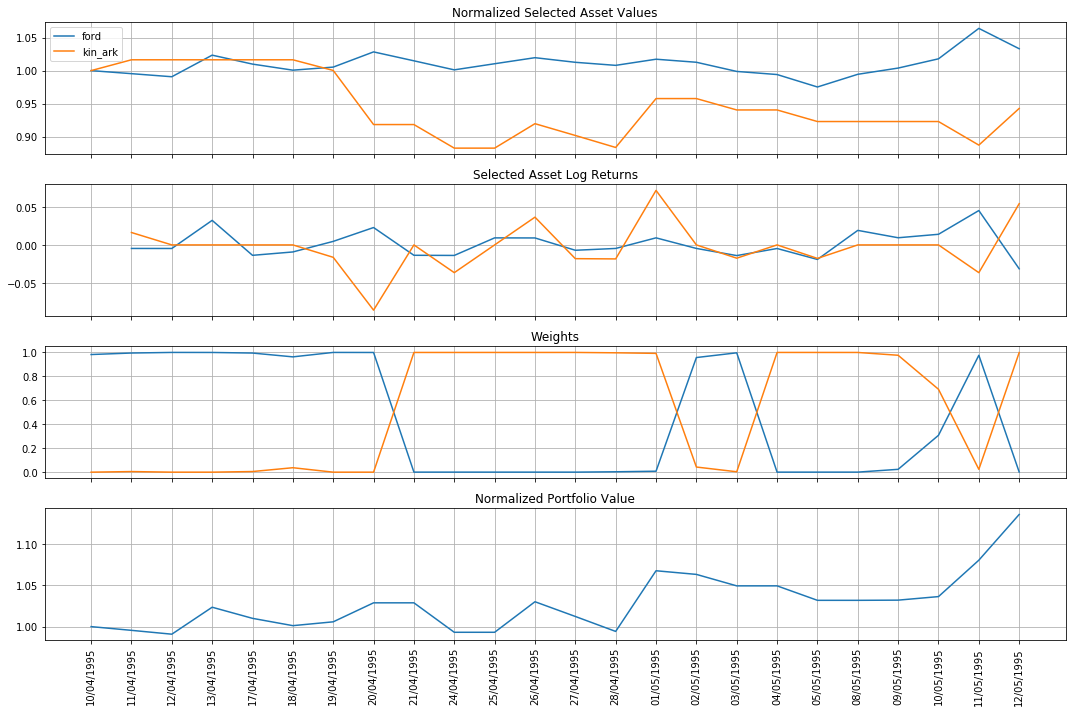

In [18]:
# Plot fully explained subset
fig, axs = plt.subplots(4, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

# Assets
axs[0].set_title('Normalized Selected Asset Values')
for a in subset_assets:
    axs[0].plot(normalized_subset_assets_df[a], label=a)
axs[0].grid()
axs[0].legend()

# Asset Returns
axs[1].set_title('Selected Asset Log Returns')
for a in subset_assets:
    axs[1].plot(log_return_subset_assets_df[a], label=a)
axs[1].grid()
#axs[1].legend()

# Weights
axs[2].set_title('Weights')
for a in subset_assets:
    axs[2].plot(subset_weights_df[a], label=a)
axs[2].grid()
#axs[2].legend()

# Portfolio Value
axs[3].set_title('Normalized Portfolio Value')
axs[3].plot(subset_portfolio_df[model_dict['name']], label=model_dict['name'])
axs[3].grid()

plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
plt.show()

### General Overview

In [19]:
# Find the asset with the greatest weight for each day
picked_stocks = weights_df.idxmax(axis=1)
picked_stocks.unique()

array(['ford', 'kin_ark', 'blank'], dtype=object)

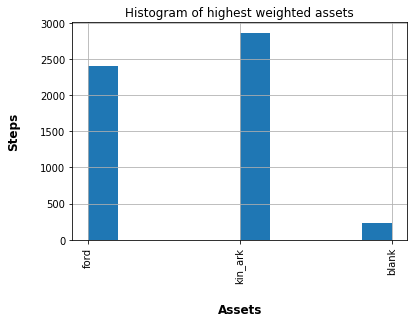

In [20]:
# Histogram of the stocks selected by the agent
fig, ax = plt.subplots(1, 1)
picked_stocks_hist = ax.hist(picked_stocks)

ax.grid()

# Remove title
ax.set_title("Histogram of highest weighted assets")

# Set x-axis label
ax.set_xlabel("Assets", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Steps", labelpad=20, weight='bold', size=12)

# Rotate labels on x-axis
plt.xticks(rotation='vertical')
plt.show()

In [21]:
# Concat with the Portfolio datatable
picked_stocks.name="stocks"
stocks_df = pd.concat([picked_stocks, portfolio_df], axis=1)
stocks_df['index'] = list(range(len(stocks_df)))
#stocks_df.head()

In [22]:
# Normalized asset values
##normalized_assets_df=(assets_df-assets_df.min())/(assets_df.max()-assets_df.min())
diff_assets_df = assets_df - assets_df.shift(1)
normalized_assets_df = diff_assets_df.cumsum() + 1
normalized_assets_df.iloc[0] = 1
normalized_assets_df.head()

# Normalized
#normalized_assets_df = ((assets_df / assets_df.shift(1)) - 1).cumsum() + 1
#normalized_assets_df.iloc[0] = 1
#normalized_assets_df.head()

# Actual asset values
_start = np.where(full_assets_df.index==train_start_date)[0][0]
_end = np.where(full_assets_df.index==train_end_date)[0][0]
temp_full_assets_df = full_assets_df[_start : _end]

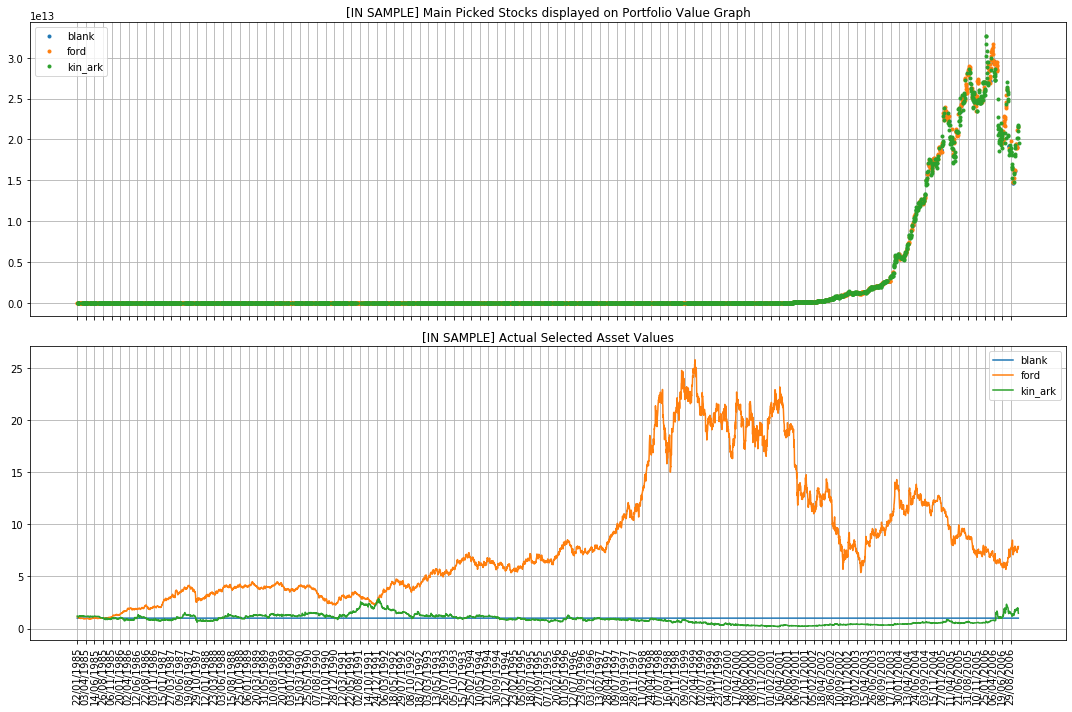

In [23]:
fig, axs = plt.subplots(2, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

# Main Picked Stocks displayed on Portfolio Value Graph
axs[0].set_title('[IN SAMPLE] Main Picked Stocks displayed on Portfolio Value Graph')
groups = stocks_df.groupby("stocks")
for name, group in groups:
    axs[0].plot(group['index'], group[model_dict['name']], marker=".", linestyle="", label=name)
axs[0].grid()
axs[0].legend()

# Main Picked Stock Prices
axs[1].set_title('[IN SAMPLE] Actual Selected Asset Values')
done_names = []
for name, group in groups:
    axs[1].plot(temp_full_assets_df[name], label=name)
    done_names.append(name)
for name in [a for a in subset_assets if a not in done_names]:
    axs[1].plot(temp_full_assets_df[name], label=name)
axs[1].grid()
axs[1].legend()

plt.xticks(np.arange(0, len(dates), 50))
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
plt.show()

---------------
## OUT OF SAMPLE

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<Figure size 432x288 with 0 Axes>

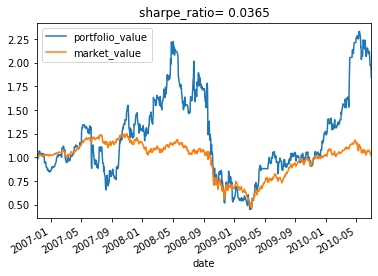

In [24]:
# Compiled Results
framework = model_dict['framework']
window_length = model_dict['window']
technical_indicators_flag = model_dict['technical_indicators_flag']
name = model_dict['name']
model = model_dict['model']

if technical_indicators_flag:
    env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                          end_date=test_end_date, window_length=window_length, 
                              technical_indicators_flag=True, 
                              technical_indicator_history=ti_dict[window_length])
else:
    env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                          end_date=test_end_date, window_length=window_length)


dates, observations, _, actions, weights_list, _, portfolio_values, market_portfolio_values = test_model(env, model)

model_dict['actions'] = actions
model_dict['portfolio_values'] = portfolio_values

#### Plot and Results

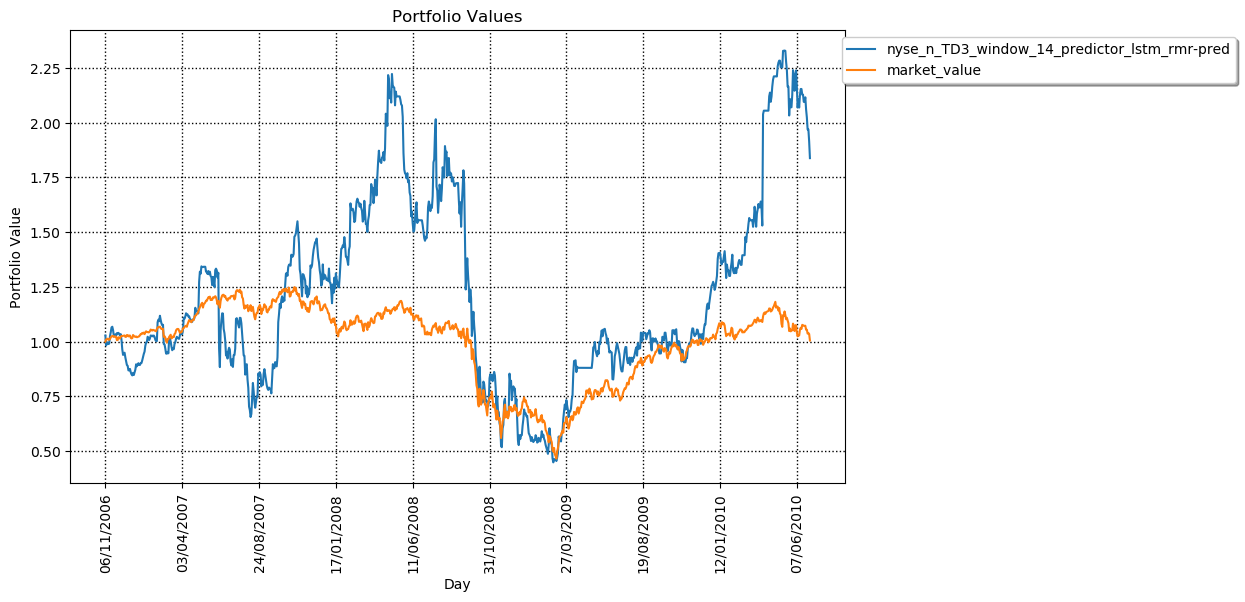

In [25]:
log_y = False
portfolio_df = pd.DataFrame()
portfolio_df["Date"] = dates
portfolio_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')
# Models
portfolio_df[model_dict['name']] = model_dict['portfolio_values']
plt.plot(portfolio_df[model_dict['name']], label=model_dict['name'])
# Market
portfolio_df['market_value'] = market_portfolio_values
plt.plot(portfolio_df['market_value'], label='market_value')
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [26]:
# RESULT
df = pd.DataFrame(columns=['Portfolio', 'Average Daily Yield (%)', 'Sharpe Ratio (%)', 'Sortino Ratio (%)', 'Maximum Drawdown (%)',
                           'Final Portfolio Value'])

df = results_table_row(df, model_dict['name'],
                           returns_from_cumulative(model_dict['portfolio_values']),
                           model_dict['portfolio_values'])
# Market
df = results_table_row(df, 'market_value',
                           returns_from_cumulative(market_portfolio_values),
                           market_portfolio_values)
df

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,nyse_n_TD3_window_14_predictor_lstm_rmr-pred,0.1511,3.5843,5.2605,79.8014,1.838
1,market_value,0.0184,0.9736,1.2451,62.6889,1.005


#### Assets

In [27]:
full_assets = assets.copy()
full_assets.insert(0,'blank')
full_assets[0:5]

['blank', 'ahp', 'alcoa', 'amer_brands', 'coke']

In [28]:
# Asset Dataframe (return)
full_assets_df = pd.DataFrame(columns=assets)
for i in range(len(assets)):
    full_assets_df[assets[i]] = [item[1] for item in history[i]]
full_assets_df["blank"] = 1
full_assets_df["Date"] = date_list
full_assets_df.set_index('Date', inplace=True)

# testing subset
_start = np.where(full_assets_df.index==test_start_date)[0][0]
_end = np.where(full_assets_df.index==test_end_date)[0][0]
assets_df = full_assets_df[_start : _end]
assets_df.head()

,ahp,alcoa,amer_brands,coke,comm_metals,dow_chem,Dupont,ford,ge,gm,...,kimb-clark,kin_ark,Kodak,merck,mmm,morris,p_and_g,schlum,sher_will,blank
Date,,,,,,,,,,,,,,,,,,,,,
03/11/2006,15.840015,9.877542,18.078393,27.149466,24.242457,15.265952,11.397742,7.741848,25.539644,3.007292,...,20.524804,1.455938,2.160663,31.674667,15.500797,62.603422,30.080099,11.420342,25.139342,1
06/11/2006,16.127194,9.991924,18.296961,27.330553,24.477609,15.495247,11.607574,8.000503,25.906904,3.048582,...,20.599515,1.391935,2.181816,32.173227,15.699982,62.680424,30.155901,11.573260,25.770591,1
07/11/2006,16.266050,10.005813,18.262014,27.394779,24.369173,15.348662,11.569617,8.065147,26.105351,3.041539,...,20.549664,1.410601,2.176732,32.236286,15.666384,61.947690,30.416750,11.512153,26.179827,1
08/11/2006,16.142916,9.960687,18.364281,27.371494,24.513926,15.374908,11.744087,7.972801,26.134850,3.048565,...,20.580899,1.410601,2.235961,31.140575,15.666384,62.811241,30.383595,11.740554,26.458381,1
09/11/2006,15.419713,10.057803,18.378238,27.237100,24.685769,15.310949,11.946320,7.908141,25.921851,3.034512,...,20.543442,1.431929,2.206357,30.115116,15.563769,62.356487,30.269657,11.684787,26.258091,1


#### Weights

In [29]:
# Create Dataframe for weights
weights_df = pd.DataFrame(weights_list, columns=full_assets)
weights_df["Date"] = dates
weights_df.set_index('Date', inplace=True)
weights_df.head()

,blank,ahp,alcoa,amer_brands,coke,comm_metals,dow_chem,Dupont,ford,ge,...,jnj,kimb-clark,kin_ark,Kodak,merck,mmm,morris,p_and_g,schlum,sher_will
Date,,,,,,,,,,,,,,,,,,,,,
06/11/2006,1.001325e-08,9.339035e-11,1.018510e-10,8.757429e-11,1.137137e-10,6.011656e-12,3.192305e-11,7.148137e-11,0.000170,6.593807e-11,...,6.151253e-11,5.811793e-11,0.999830,7.402171e-11,4.033599e-10,5.971889e-11,4.694558e-10,1.229610e-10,1.204885e-11,1.193971e-10
07/11/2006,1.021206e-08,1.483368e-10,1.551103e-10,1.866799e-10,1.707695e-10,1.019123e-11,8.677448e-11,2.291695e-10,0.001027,1.060698e-10,...,9.382701e-11,1.599833e-10,0.998973,1.283038e-10,1.563540e-09,1.929241e-10,1.617236e-09,1.950003e-10,1.936185e-11,1.910088e-10
08/11/2006,1.007113e-08,4.288984e-10,4.642320e-10,4.035272e-10,5.144229e-10,3.305071e-11,1.570263e-10,3.332081e-10,0.000305,3.089269e-10,...,2.899693e-10,2.751528e-10,0.999695,3.452315e-10,1.671429e-09,2.815049e-10,1.938311e-09,5.534353e-10,6.327856e-11,5.393132e-10
09/11/2006,6.994412e-08,8.443344e-11,7.958580e-11,2.470176e-10,8.527016e-11,5.591084e-12,2.064437e-10,9.343368e-10,0.069880,6.134403e-11,...,4.609342e-11,4.128214e-10,0.930120,9.201702e-11,1.341786e-08,8.014505e-10,9.216026e-09,1.149225e-10,9.589902e-12,1.147392e-10
10/11/2006,7.169830e-06,8.988285e-12,7.525940e-12,6.775458e-11,7.787976e-12,6.332374e-13,1.136569e-10,9.123730e-10,0.926475,6.747212e-12,...,4.237925e-12,2.439113e-10,0.073518,1.280391e-11,2.823913e-08,8.025307e-10,1.221881e-08,1.258470e-11,9.465528e-13,1.285135e-11


### Subset for Granular Testing

In [30]:
# Subset by From and To Dates
from_date = '07/02/2008'
to_date = '11/06/2008'
subset_dates = date_list[date_list.index(from_date)-1 : 
                  date_list.index(to_date)]
_start = np.where(weights_df.index==from_date)[0][0]
_end = np.where(weights_df.index==to_date)[0][0]
subset_weights_df = weights_df[_start : _end]

# Normalised Subset Portfolio
subset_portfolio_df = portfolio_df[_start : _end]
subset_portfolio_df = ((subset_portfolio_df / subset_portfolio_df.shift(1)) - 1).cumsum() + 1
subset_portfolio_df.iloc[0] = 1

subset_assets = subset_weights_df.idxmax(axis=1).unique()
subset_assets_df = assets_df[_start : _end]
#subset_assets_df = subset_assets_df[subset_assets]

# Normalized
#diff_subset_assets_df = subset_assets_df - subset_assets_df.shift(1)
#normalized_subset_assets_df = diff_subset_assets_df.cumsum() + 1
#normalized_subset_assets_df.iloc[0] = 1

# Normalized
normalized_subset_assets_df = ((subset_assets_df / subset_assets_df.shift(1)) - 1).cumsum() + 1
normalized_subset_assets_df.iloc[0] = 1

# Log Return
log_return_subset_assets_df = np.log(subset_assets_df / subset_assets_df.shift(1))
log_return_subset_assets_df.head()

,ahp,alcoa,amer_brands,coke,comm_metals,dow_chem,Dupont,ford,ge,gm,...,kimb-clark,kin_ark,Kodak,merck,mmm,morris,p_and_g,schlum,sher_will,blank
Date,,,,,,,,,,,,,,,,,,,,,
06/02/2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07/02/2008,0.005893,0.011355,-0.001521,0.012739,0.008692,-0.003426,0.009782,-0.022440,0.000880,0.022691,...,-0.003687,0.007184,0.033203,-0.000220,-0.000760,0.018252,0.036255,0.011948,0.024068,0.0
08/02/2008,-0.005887,0.029462,-0.016373,0.013597,0.005037,0.015184,0.005734,-0.014697,-0.011455,-0.019193,...,-0.007558,0.021243,-0.008325,-0.025933,-0.007105,-0.013724,0.022202,0.021027,-0.009959,0.0
11/02/2008,-0.022051,0.008851,0.003544,0.004211,0.021996,-0.012285,0.010722,0.049733,0.005007,0.049894,...,0.002168,0.020802,0.011948,0.017368,0.009118,-0.009212,0.040067,0.039538,0.000180,0.0
12/02/2008,-0.011981,-0.016882,0.001539,0.007035,-0.011294,0.017722,0.025580,0.010890,0.010534,-0.019356,...,0.013814,-0.051020,-0.001031,0.026574,-0.002273,0.000140,0.002906,0.012344,-0.000360,0.0


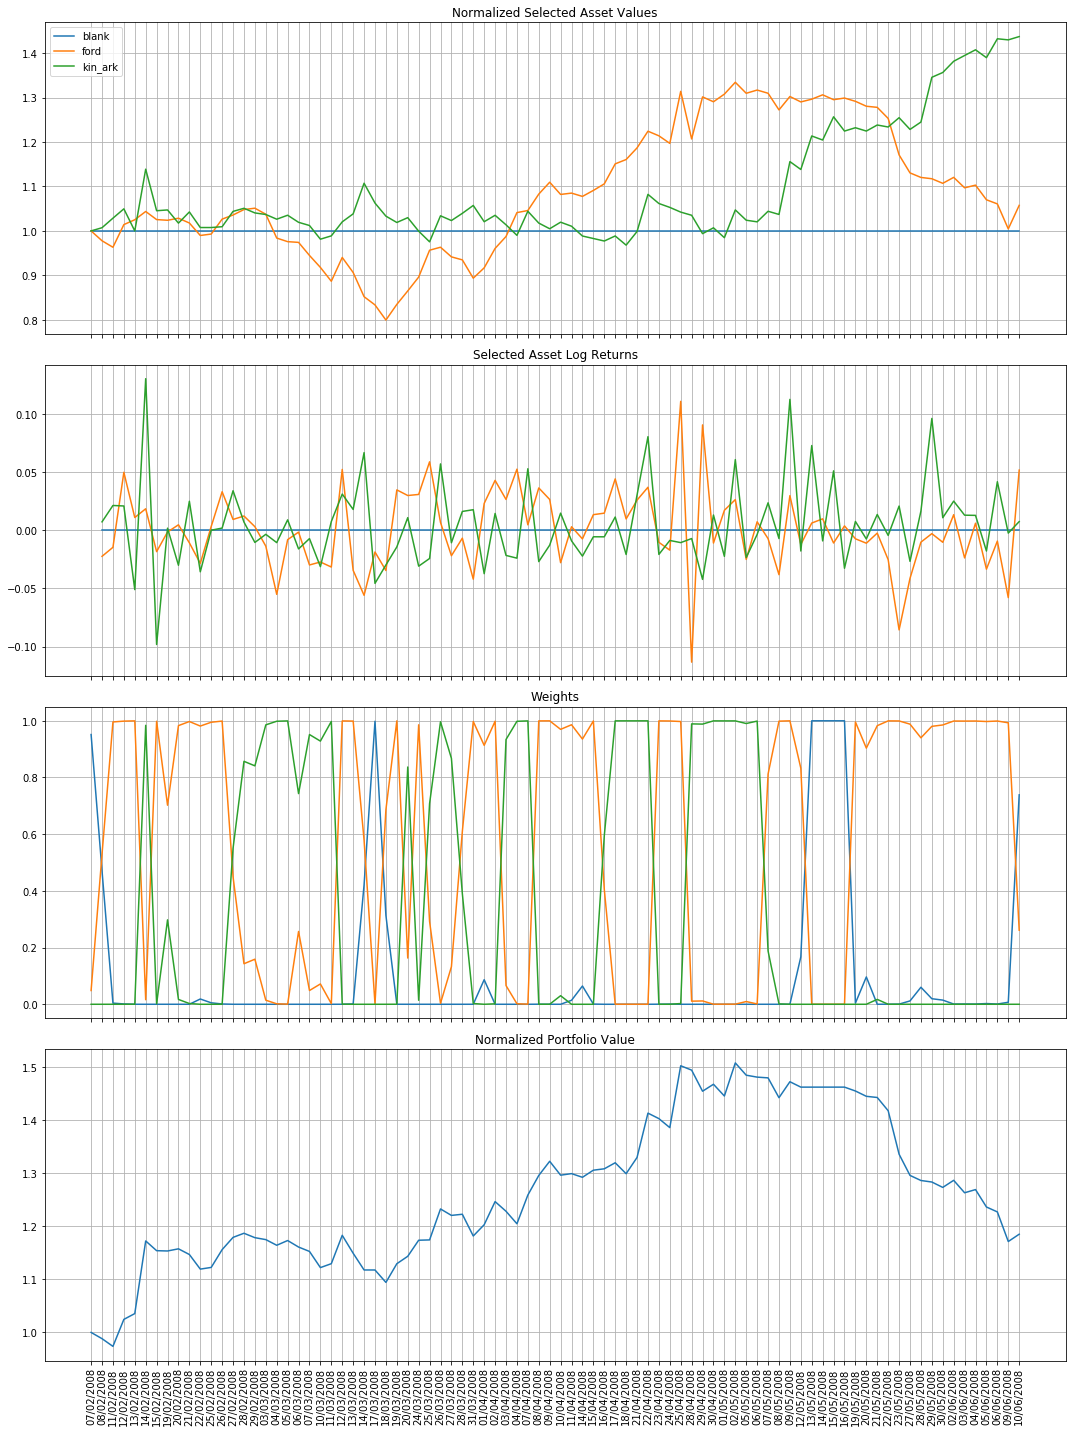

In [31]:
# Plot fully explained subset
fig, axs = plt.subplots(4, sharex=True)
fig.set_figheight(20)
fig.set_figwidth(15)

# Assets
axs[0].set_title('Normalized Selected Asset Values')
for a in subset_assets:
    axs[0].plot(normalized_subset_assets_df[a], label=a)
axs[0].grid()
axs[0].legend()

# Asset Returns
axs[1].set_title('Selected Asset Log Returns')
for a in subset_assets:
    axs[1].plot(log_return_subset_assets_df[a], label=a)
axs[1].grid()
#axs[1].legend()

# Weights
axs[2].set_title('Weights')
for a in subset_assets:
    axs[2].plot(subset_weights_df[a], label=a)
axs[2].grid()
#axs[2].legend()

# Portfolio Value
axs[3].set_title('Normalized Portfolio Value')
axs[3].plot(subset_portfolio_df[model_dict['name']], label=model_dict['name'])
axs[3].grid()

plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
plt.show()

### General Overview

In [32]:
# Find the asset with the greatest weight for each day
picked_stocks = weights_df.idxmax(axis=1)
picked_stocks.unique()

array(['kin_ark', 'ford', 'blank'], dtype=object)

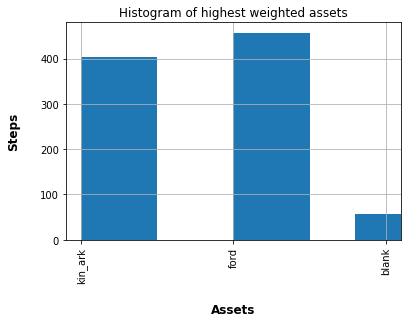

In [33]:
# Histogram of the stocks selected by the agent
fig, ax = plt.subplots(1, 1)
picked_stocks_hist = ax.hist(picked_stocks, width=0.5)

ax.grid()

# Remove title
ax.set_title("Histogram of highest weighted assets")

# Set x-axis label
ax.set_xlabel("Assets", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Steps", labelpad=20, weight='bold', size=12)

# Rotate labels on x-axis
plt.xticks(rotation='vertical')
plt.show()

In [34]:
# Concat with the Portfolio datatable
picked_stocks.name="stocks"
stocks_df = pd.concat([picked_stocks, portfolio_df], axis=1)
stocks_df['index'] = list(range(len(stocks_df)))
stocks_df.head()

,stocks,nyse_n_TD3_window_14_predictor_lstm_rmr-pred,market_value,index
Date,,,,
06/11/2006,kin_ark,1.028242,1.000527,0
07/11/2006,kin_ark,0.983121,1.009940,1
08/11/2006,kin_ark,0.996303,1.011673,2
09/11/2006,kin_ark,0.995503,1.013656,3
10/11/2006,ford,0.989121,1.008790,4


In [35]:
# Normalized asset values
##normalized_assets_df=(assets_df-assets_df.min())/(assets_df.max()-assets_df.min())
#diff_assets_df = assets_df - assets_df.shift(1)
#normalized_assets_df = diff_assets_df.cumsum() + 1
#normalized_assets_df.iloc[0] = 1
#normalized_assets_df.head()

# Normalized
normalized_assets_df = ((assets_df / assets_df.shift(1)) - 1).cumsum() + 1
normalized_assets_df.iloc[0] = 1
normalized_assets_df.head()

# Actual asset values
_start = np.where(full_assets_df.index==test_start_date)[0][0]
_end = np.where(full_assets_df.index==test_end_date)[0][0]
temp_full_assets_df = full_assets_df[_start : _end]

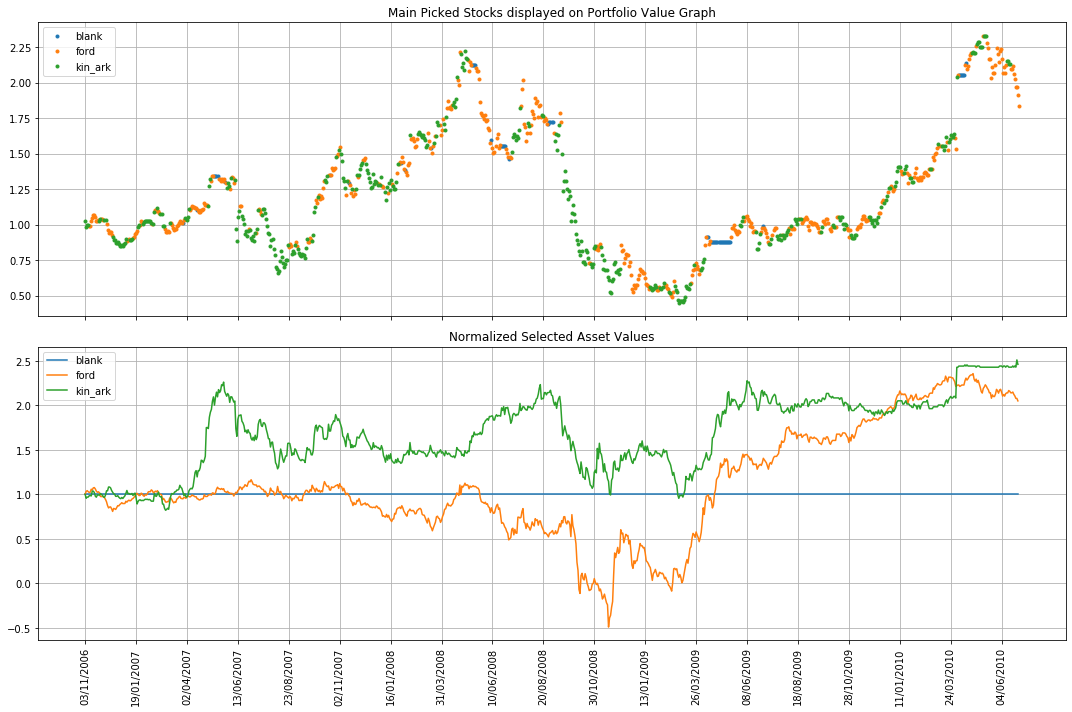

In [36]:
fig, axs = plt.subplots(2, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

# Main Picked Stocks displayed on Portfolio Value Graph
axs[0].set_title('Main Picked Stocks displayed on Portfolio Value Graph')
groups = stocks_df.groupby("stocks")
for name, group in groups:
    axs[0].plot(group['index'], group[model_dict['name']], marker=".", linestyle="", label=name)
axs[0].grid()
axs[0].legend()

# Main Picked Stock Prices
axs[1].set_title('Normalized Selected Asset Values')
done_names = []
for name, group in groups:
    axs[1].plot(normalized_assets_df[name], label=name)
    done_names.append(name)
# Add to include plots of other assets
#for name in [a for a in subset_assets if a not in done_names]:
#    axs[1].plot(normalized_assets_df[name], label=name)
axs[1].grid()
axs[1].legend()

# Main Picked Stock Prices
#axs[2].set_title('Actual Selected Asset Values')
#done_names = []
#for name, group in groups:
#    axs[2].plot(temp_full_assets_df[name], label=name)
#   done_names.append(name)
# Add to include plots of other assets
#for name in [a for a in subset_assets if a not in done_names]:
#    axs[2].plot(temp_full_assets_df[name], label=name)
#axs[2].grid()
#axs[2].legend()


plt.xticks(np.arange(0, len(dates), 50))
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
plt.show()

--------
## Pie Charts

In [37]:
# Return
return_subset_assets_df = subset_assets_df / subset_assets_df.shift(1)

# Mean Weights
mean_weights = []
mean_daily_yields = []
total_yields = []
asset_names = []
for a, group in groups:
    mean_weights.append(weights_df[a].mean())
    mean_daily_yields.append(return_subset_assets_df[a].mean())
    total_yields.append(return_subset_assets_df[a].sum())
    asset_names.append(a)

df = pd.DataFrame({'Average Allocated Weight': mean_weights,
                  'Average Daily Yield': mean_daily_yields,
                  'Total Yields': total_yields},
                  index=asset_names)

df.head()

,Average Allocated Weight,Average Daily Yield,Total Yields
blank,0.067754,1.000000,85.00000
ford,0.493576,1.000677,85.05753
kin_ark,0.438670,1.005146,85.43741


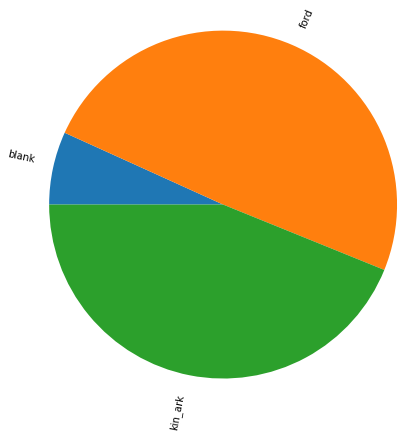

In [38]:
fig, ax = plt.subplots()
# Average Allocated Weight
pie2 = ax.pie(df['Average Allocated Weight'], radius=2,  labeldistance=1.1, labels=asset_names, 
              rotatelabels=True, startangle=180,counterclock=False)

plt.show()

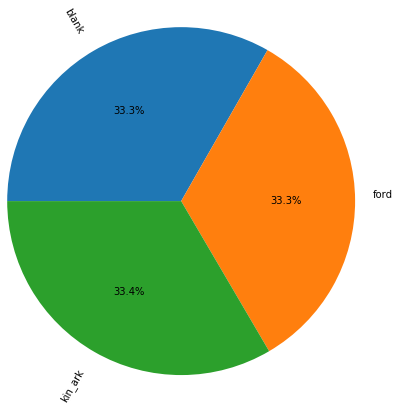

In [39]:
fig, ax = plt.subplots()
# Average Daily Yield
pie2 = ax.pie(df['Average Daily Yield'], radius=2,  labeldistance=1.1, labels=asset_names, 
              rotatelabels=True, startangle=180,counterclock=False, autopct='%1.1f%%')

plt.show()

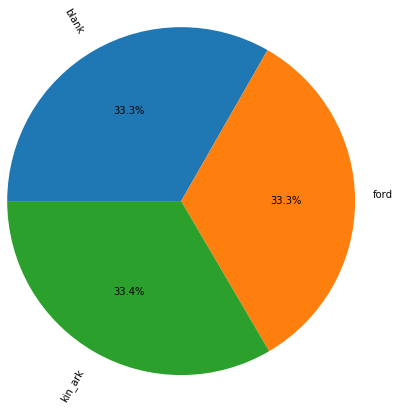

In [40]:
fig, ax = plt.subplots()
# Total Yield
pie2 = ax.pie(df['Total Yields'], radius=2,  labeldistance=1.1, labels=asset_names, 
              rotatelabels=True, startangle=180,counterclock=False, autopct='%1.1f%%')

plt.show()